#0_HTEPINNs_solverでScipyを使うようにしたので、それを踏まえて全体をアップデートする。

(100, 180)


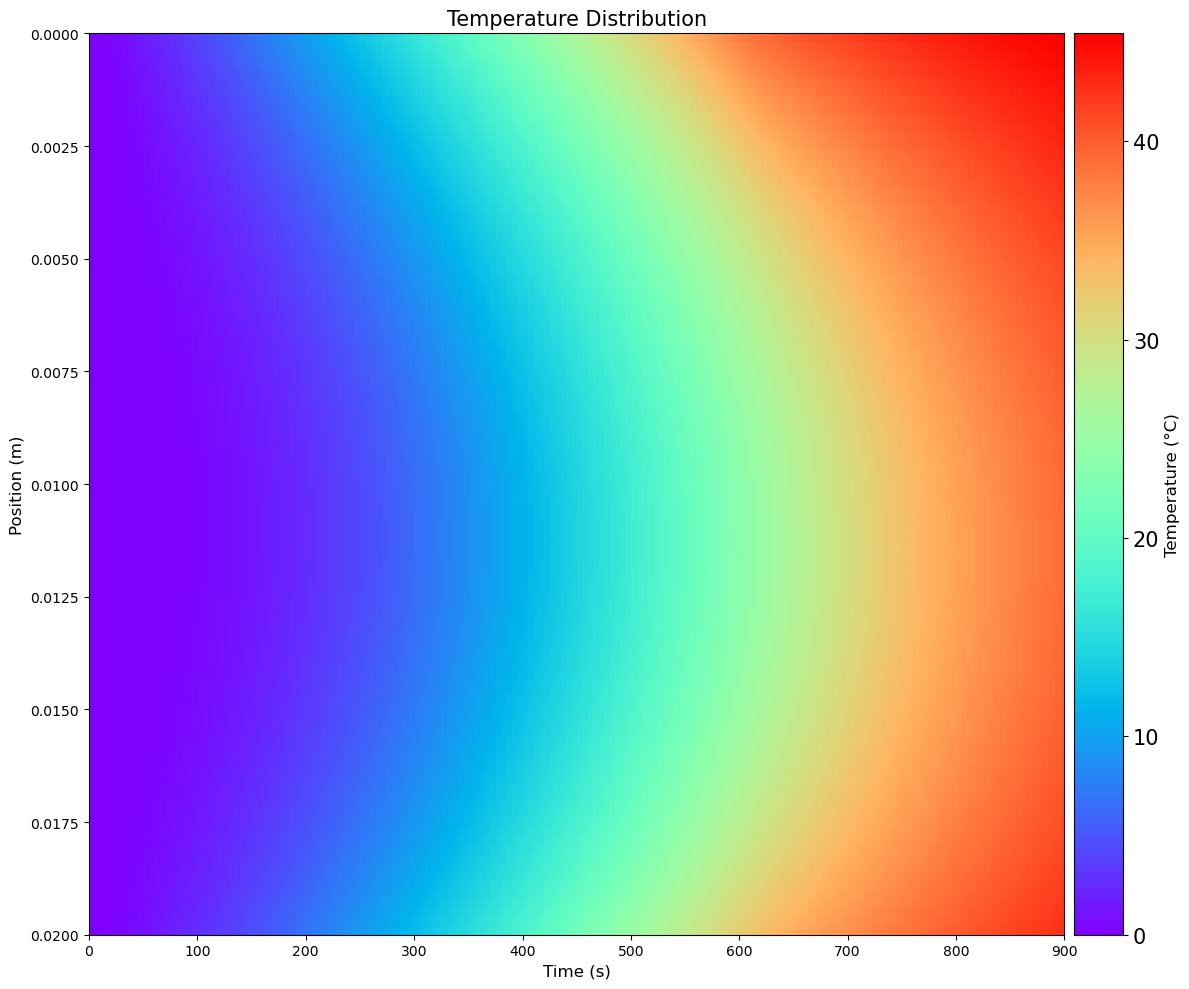

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
from collections import OrderedDict
from pyDOE import lhs
from scipy.interpolate import griddata
import time

np.random.seed(1234)

# パラメータ
K = 0.47
rho = 1573
cp = 967
alpha = K / (rho * cp)
h1 = 100
h2 = 50
L = 0.02  # 材料の長さ
t_max = 900  # シミュレーション時間
lambda_f, lambda_BC0, lambda_BC1, lambda_BC2 = 1.0, 1.0, 1.0, 1.0
N_u = 200
N_f = 10000
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

# 境界条件
def T_ext(t):
    return 50 * min(t / 600, 1)

# PDEの右辺
def heat_equation(t, u):
    dudt = np.zeros_like(u)
    dx = L / (len(u) - 1)
    
    # 内部点
    dudt[1:-1] = alpha * (u[:-2] - 2*u[1:-1] + u[2:]) / dx**2
    
    # 左端（x=0）
    dudt[0] = (2*alpha/dx**2) * (u[1] - u[0]) + (2*h1/(rho*cp*dx)) * (T_ext(t) - u[0])
    
    # 右端（x=L）
    dudt[-1] = (2*alpha/dx**2) * (u[-2] - u[-1]) + (2*h2/(rho*cp*dx)) * (T_ext(t) - u[-1])
    
    return dudt

# 空間グリッドの設定
Nx = 100
x = np.linspace(0, L, Nx)

# 初期条件
u0 = np.zeros(Nx)

# 時間グリッドの設定
t_eval = np.linspace(0, t_max, 180)

# ODEソルバーの実行
sol = solve_ivp(heat_equation, [0, t_max], u0, t_eval=t_eval, method='RK45')

print(sol.y.shape)  # 形状の確認

# 結果の可視化
fig, ax = plt.subplots(figsize=(12, 10))
h_img = ax.imshow(sol.y, interpolation='nearest', cmap='rainbow', 
                  extent=[t_eval.min(), t_eval.max(), x.max(), x.min()],
                  aspect='auto', origin='upper')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h_img, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature (°C)', fontsize=12)
ax.set_title('Temperature Distribution', fontsize=15)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Position (m)', fontsize=12)
plt.tight_layout()
plt.show()